In [39]:
#
import pandas
from statsmodels.tsa.seasonal import MSTL
from matplotlib import pyplot
from scipy import stats

#
import numpy
from sklearn.ensemble import RandomForestRegressor

#


In [21]:
driver = 'JTU5300QUL'
# driver = 'QUSR628BIS'
# driver = 'RAILFRTCARLOADSD11'
# driver = 'FRGSHPUSM649NCIS'
# driver = 'TSIFRGHT'
# driver = 'AIRRTMFMD11'
# driver = 'CUUR0000SEHA'
series = pandas.read_csv('./data/{0}.csv'.format(driver))
# series = data[[driver]].copy()
# series = series.reset_index().rename(columns={'jx': 'ds', driver: 'y'})
series = series.rename(columns={'DATE': 'ds', driver: 'y'})
series['ds'] = pandas.to_datetime(series['ds'])
series['y'] = series['y'].apply(func=lambda x: pandas.NA if x == '.' else x)
series['y'] = series['y'].ffill()
series['y'] = pandas.to_numeric(series['y'])
series = series[series['ds'] > '1970-01-01']
series = series.rename(columns={'ds': 'DATE', 'y': driver})
# series['y'] = series['y'].pct_change()
# series = series[series['ds'] > '2000-01-01']
series

,DATE,JTU5300QUL
0,2000-12-01,50
1,2001-01-01,80
2,2001-02-01,29
3,2001-03-01,28
4,2001-04-01,52
...,...,...
266,2023-02-01,42
267,2023-03-01,44
268,2023-04-01,56
269,2023-05-01,39


In [22]:
# series.set_index('ds').iloc[80:120, :].plot(style='.')  # '.-'

In [23]:
series.set_index('ds').plot(style='.-')  # '.-'

KeyError: "None of ['ds'] are in the columns"

In [24]:
def make_lags(frame, nl):
    cols = frame.columns.values
    for j in range(nl):
        cols_lagged = ['{0}_LAG{1}'.format(c, j+1) for c in cols]
        frame[cols_lagged] = frame[cols].shift(j+1)
    return frame

In [40]:
f = driver
l = 40
data_lag = series.iloc[:200, :].copy()
data_train = series.iloc[200:400, :].copy()
data_test = series.iloc[400:, :].copy()

data_joint = pandas.concat((data_lag, data_train, data_test), axis=0, ignore_index=True)
data_joint = make_lags(frame=data_joint, nl=l)

# .iloc[data_lag.shape[0]:, :]

x_factors = [c for c in data_joint.columns if ((f in c) and ('LAG' in c))]

sub_train = data_joint.iloc[l:data_lag.shape[0], :].copy()
x_sub_train = sub_train[x_factors].values
y_sub_train = sub_train[f].values

model = RandomForestRegressor()
model.fit(X=x_sub_train, y=y_sub_train)

preds = data_joint.iloc[data_lag.shape[0]:, :].copy()
preds['{0}_rf_hat'.format(f)] = model.predict(X=preds[x_factors].values)
stds = numpy.concatenate([model.predict(preds[x_factors].values).reshape(-1, 1) for tree in model.estimators_], axis=1).std(axis=1, ddof=1) / numpy.power(len(model.estimators_), 0.5)
preds['{0}_rf_hat_upper'.format(f)] = preds['{0}_rf_hat'.format(f)] + stats.t.ppf(q=0.975, df=(len(model.estimators_)-1)) * stds
preds['{0}_rf_hat_lower'.format(f)] = preds['{0}_rf_hat'.format(f)] + stats.t.ppf(q=0.025, df=(len(model.estimators_)-1)) * stds
jets = preds[['DATE', '{0}_rf_hat'.format(f), '{0}_rf_hat_upper'.format(f), '{0}_rf_hat_lower'.format(f), f]].copy()

In [46]:
jets

,DATE,JTU5300QUL_rf_hat,JTU5300QUL_rf_hat_upper,JTU5300QUL_rf_hat_lower,JTU5300QUL
200,2017-08-01,36.85,36.85,36.85,46
201,2017-09-01,35.64,35.64,35.64,31
202,2017-10-01,32.79,32.79,32.79,46
203,2017-11-01,33.08,33.08,33.08,23
204,2017-12-01,27.69,27.69,27.69,28
...,...,...,...,...,...
266,2023-02-01,37.09,37.09,37.09,42
267,2023-03-01,33.36,33.36,33.36,44
268,2023-04-01,39.95,39.95,39.95,56
269,2023-05-01,44.19,44.19,44.19,39


In [37]:
beds.shape

(71,)

In [27]:
data_joint

,DATE,JTU5300QUL,DATE_LAG1,JTU5300QUL_LAG1,DATE_LAG2,JTU5300QUL_LAG2,DATE_LAG3,JTU5300QUL_LAG3,DATE_LAG4,JTU5300QUL_LAG4,...,DATE_LAG36,JTU5300QUL_LAG36,DATE_LAG37,JTU5300QUL_LAG37,DATE_LAG38,JTU5300QUL_LAG38,DATE_LAG39,JTU5300QUL_LAG39,DATE_LAG40,JTU5300QUL_LAG40
0,2000-12-01,50,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
1,2001-01-01,80,2000-12-01,50.0,NaT,NaN,NaT,NaN,NaT,NaN,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
2,2001-02-01,29,2001-01-01,80.0,2000-12-01,50.0,NaT,NaN,NaT,NaN,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
3,2001-03-01,28,2001-02-01,29.0,2001-01-01,80.0,2000-12-01,50.0,NaT,NaN,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
4,2001-04-01,52,2001-03-01,28.0,2001-02-01,29.0,2001-01-01,80.0,2000-12-01,50.0,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,2023-02-01,42,2023-01-01,52.0,2022-12-01,35.0,2022-11-01,48.0,2022-10-01,53.0,...,2020-02-01,31.0,2020-01-01,52.0,2019-12-01,38.0,2019-11-01,46.0,2019-10-01,43.0
267,2023-03-01,44,2023-02-01,42.0,2023-01-01,52.0,2022-12-01,35.0,2022-11-01,48.0,...,2020-03-01,28.0,2020-02-01,31.0,2020-01-01,52.0,2019-12-01,38.0,2019-11-01,46.0
268,2023-04-01,56,2023-03-01,44.0,2023-02-01,42.0,2023-01-01,52.0,2022-12-01,35.0,...,2020-04-01,25.0,2020-03-01,28.0,2020-02-01,31.0,2020-01-01,52.0,2019-12-01,38.0
269,2023-05-01,39,2023-04-01,56.0,2023-03-01,44.0,2023-02-01,42.0,2023-01-01,52.0,...,2020-05-01,19.0,2020-04-01,25.0,2020-03-01,28.0,2020-02-01,31.0,2020-01-01,52.0


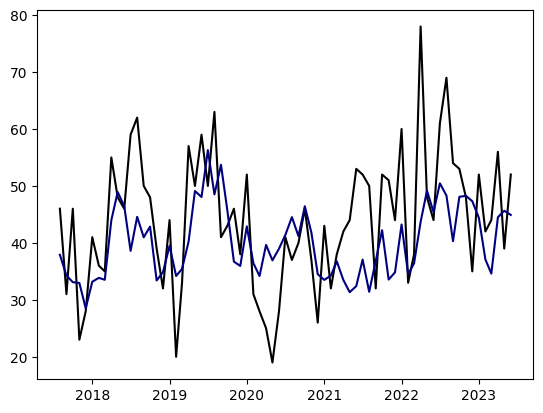

In [28]:
pyplot.plot(preds['DATE'].values, preds[f].values, 'black')
pyplot.plot(preds['DATE'].values, preds['{0}_rf_hat'.format(f)].values, 'navy')

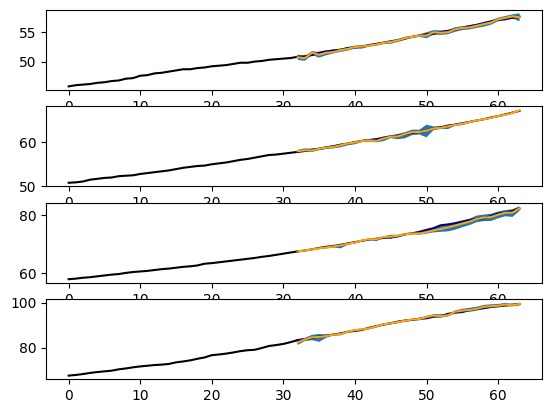

In [10]:
fig

In [11]:
y_dev

,ds,y
662,1970-02-01,45.8
663,1970-03-01,46.0
664,1970-04-01,46.1
665,1970-05-01,46.2
666,1970-06-01,46.4
...,...,...
978,1996-06-01,161.7
979,1996-07-01,162.2
980,1996-08-01,162.5
981,1996-09-01,162.9


In [29]:
jets = preds[['DATE', '{0}_rf_hat_lower'.format(f), '{0}_rf_hat_upper'.format(f), '{0}_rf_hat'.format(f)]].copy()
jets = jets.merge(right=data_joint, left_on='DATE', right_on='DATE', how='left')
jets

,DATE,JTU5300QUL_rf_hat_lower,JTU5300QUL_rf_hat_upper,JTU5300QUL_rf_hat,JTU5300QUL,DATE_LAG1,JTU5300QUL_LAG1,DATE_LAG2,JTU5300QUL_LAG2,DATE_LAG3,...,DATE_LAG36,JTU5300QUL_LAG36,DATE_LAG37,JTU5300QUL_LAG37,DATE_LAG38,JTU5300QUL_LAG38,DATE_LAG39,JTU5300QUL_LAG39,DATE_LAG40,JTU5300QUL_LAG40
0,2017-08-01,NaN,NaN,37.91,46,2017-07-01,38.0,2017-06-01,47.0,2017-05-01,...,2014-08-01,49.0,2014-07-01,38.0,2014-06-01,29.0,2014-05-01,35.0,2014-04-01,34.0
1,2017-09-01,NaN,NaN,34.28,31,2017-08-01,46.0,2017-07-01,38.0,2017-06-01,...,2014-09-01,37.0,2014-08-01,49.0,2014-07-01,38.0,2014-06-01,29.0,2014-05-01,35.0
2,2017-10-01,NaN,NaN,33.10,46,2017-09-01,31.0,2017-08-01,46.0,2017-07-01,...,2014-10-01,35.0,2014-09-01,37.0,2014-08-01,49.0,2014-07-01,38.0,2014-06-01,29.0
3,2017-11-01,NaN,NaN,32.96,23,2017-10-01,46.0,2017-09-01,31.0,2017-08-01,...,2014-11-01,41.0,2014-10-01,35.0,2014-09-01,37.0,2014-08-01,49.0,2014-07-01,38.0
4,2017-12-01,NaN,NaN,28.51,28,2017-11-01,23.0,2017-10-01,46.0,2017-09-01,...,2014-12-01,26.0,2014-11-01,41.0,2014-10-01,35.0,2014-09-01,37.0,2014-08-01,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2023-02-01,NaN,NaN,37.09,42,2023-01-01,52.0,2022-12-01,35.0,2022-11-01,...,2020-02-01,31.0,2020-01-01,52.0,2019-12-01,38.0,2019-11-01,46.0,2019-10-01,43.0
67,2023-03-01,NaN,NaN,34.61,44,2023-02-01,42.0,2023-01-01,52.0,2022-12-01,...,2020-03-01,28.0,2020-02-01,31.0,2020-01-01,52.0,2019-12-01,38.0,2019-11-01,46.0
68,2023-04-01,NaN,NaN,44.50,56,2023-03-01,44.0,2023-02-01,42.0,2023-01-01,...,2020-04-01,25.0,2020-03-01,28.0,2020-02-01,31.0,2020-01-01,52.0,2019-12-01,38.0
69,2023-05-01,NaN,NaN,45.64,39,2023-04-01,56.0,2023-03-01,44.0,2023-02-01,...,2020-05-01,19.0,2020-04-01,25.0,2020-03-01,28.0,2020-02-01,31.0,2020-01-01,52.0


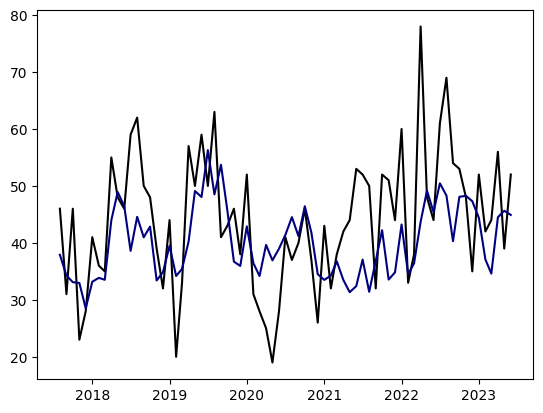

In [30]:
fig, ax = pyplot.subplots()
ax.plot(jets['DATE'].values, jets['{0}'.format(f)].values, 'black')
ax.plot(jets['DATE'].values, jets['{0}_rf_hat'.format(f)].values, 'navy')
ax.fill_between(jets['DATE'].values, jets['{0}_rf_hat_lower'.format(f)].values, jets['{0}_rf_hat_upper'.format(f)].values, alpha=0.2)

In [ ]:

data_lag = series.iloc[:200, :].copy()
data_train = series.iloc[200:400, :].copy()
data_test = series.iloc[400:, :].copy()

data_joint = pandas.concat((data_lag, data_train, data_test), axis=0, ignore_index=True)

fold_n = data_train.shape[0] + data_test.shape[0]
preds = []
for j in range(fold_n):
    y_sub = data_joint.iloc[i:data_lag.shape[0]+i].copy()
    y_pred = data_joint.iloc[[data_lag.shape[0]+i]].copy()
    
    m = Prophet(seasonality_mode='additive', interval_width=0.90, mcmc_samples=300, changepoint_prior_scale=0.005, changepoint_range=1.0)
    m.fit(y_sub)

    predictions = m.predict(y_pred)
    preds.append(predictions)
preds = pandas.concat(preds, axis=0, ignore_index=True)


04:28:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:28:21 - cmdstanpy - INFO - CmdStan done processing.
04:28:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:28:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:28:27 - cmdstanpy - INFO - CmdStan done processing.
04:28:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:28:27 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 106 iterations at max treedepth (70.7%)
	Chain 2 had 103 iterations at max treedepth (68.7%)
	Chain 3 had 112 iterations at max treedepth (74.7%)
	Chain 

04:28:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:28:34 - cmdstanpy - INFO - CmdStan done processing.
04:28:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:28:34 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:28:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:28:41 - cmdstanpy - INFO - CmdStan done processing.
04:28:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:28:41 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:28:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:28:49 - cmdstanpy - INFO - CmdStan done processing.
04:28:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:28:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:28:56 - cmdstanpy - INFO - CmdStan done processing.
04:28:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:28:56 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:28:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:29:03 - cmdstanpy - INFO - CmdStan done processing.
04:29:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:29:03 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 125 iterations at max treedepth (83.3%)
	Chain 2 had 120 iterations at max treedepth (80.0%)
	Chain 3 had 105 iterations at max treedepth (70.0%)
	Chain 

04:29:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:29:10 - cmdstanpy - INFO - CmdStan done processing.
04:29:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:29:10 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:29:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:29:17 - cmdstanpy - INFO - CmdStan done processing.
04:29:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:29:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:29:24 - cmdstanpy - INFO - CmdStan done processing.
04:29:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:29:24 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:29:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:29:32 - cmdstanpy - INFO - CmdStan done processing.
04:29:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:29:32 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 119 iterations at max treedepth (79.3%)
	Chain 2 had 128 iterations at max treedepth (85.3%)
	Chain 3 had 127 iterations at max treedepth (84.7%)
	Chain 

04:29:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:29:39 - cmdstanpy - INFO - CmdStan done processing.
04:29:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:29:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:29:46 - cmdstanpy - INFO - CmdStan done processing.
04:29:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:29:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:29:53 - cmdstanpy - INFO - CmdStan done processing.
04:29:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:29:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:30:00 - cmdstanpy - INFO - CmdStan done processing.
04:30:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:30:00 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:30:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:30:08 - cmdstanpy - INFO - CmdStan done processing.
04:30:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:30:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:30:15 - cmdstanpy - INFO - CmdStan done processing.
04:30:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:30:15 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:30:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:30:22 - cmdstanpy - INFO - CmdStan done processing.
04:30:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:30:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:30:29 - cmdstanpy - INFO - CmdStan done processing.
04:30:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:30:29 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:30:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:30:36 - cmdstanpy - INFO - CmdStan done processing.
04:30:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Except

04:30:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:30:44 - cmdstanpy - INFO - CmdStan done processing.
04:30:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:30:44 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 111 iterations at max treedepth (74.0%)
	Chain 2 had 91 iterations at max treedepth (60.7%)
	Chain 3 had 94 iterations at max treedepth (62.7%)
	Chain 4 

04:30:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:30:52 - cmdstanpy - INFO - CmdStan done processing.
04:30:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:30:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:31:00 - cmdstanpy - INFO - CmdStan done processing.
04:31:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:31:00 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 116 iterations at max treedepth (77.3%)
	Chain 2 had 112 iterations at max treedepth (74.7%)
	Chain 3 had 116 iterations at max treedepth (77.3%)
	Chain 

04:31:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:31:07 - cmdstanpy - INFO - CmdStan done processing.
04:31:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Except

04:31:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:31:15 - cmdstanpy - INFO - CmdStan done processing.
04:31:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:31:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:31:23 - cmdstanpy - INFO - CmdStan done processing.
04:31:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:31:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:31:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:31:30 - cmdstanpy - INFO - CmdStan done processing.
04:31:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:31:30 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:31:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:31:38 - cmdstanpy - INFO - CmdStan done processing.
04:31:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:31:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 108 iterations at max treedepth (72.0%)
	Chain 2 had 115 iterations at max treedepth (76.7%)
	Chain 3 had 122 iterations at max treedepth (81.3%)
	Chain 

04:31:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:31:46 - cmdstanpy - INFO - CmdStan done processing.
04:31:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:31:46 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:31:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:31:53 - cmdstanpy - INFO - CmdStan done processing.
04:31:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:31:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:32:01 - cmdstanpy - INFO - CmdStan done processing.
04:32:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:32:01 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 94 iterations at max treedepth (62.7%)
	Chain 2 had 126 iterations at max treedepth (84.0%)
	Chain 3 had 115 iterations at max treedepth (76.7%)
	Chain 4

04:32:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:32:08 - cmdstanpy - INFO - CmdStan done processing.
04:32:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:32:08 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:32:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:32:16 - cmdstanpy - INFO - CmdStan done processing.
04:32:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:32:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:32:24 - cmdstanpy - INFO - CmdStan done processing.
04:32:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:32:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:32:31 - cmdstanpy - INFO - CmdStan done processing.
04:32:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:32:31 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:32:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:32:38 - cmdstanpy - INFO - CmdStan done processing.
04:32:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:32:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:32:46 - cmdstanpy - INFO - CmdStan done processing.
04:32:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:32:46 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 125 iterations at max treedepth (83.3%)
	Chain 2 had 118 iterations at max treedepth (78.7%)
	Chain 3 had 111 iterations at max treedepth (74.0%)
	Chain 

04:32:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:32:53 - cmdstanpy - INFO - CmdStan done processing.
04:32:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:32:54 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:32:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:33:01 - cmdstanpy - INFO - CmdStan done processing.
04:33:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:33:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:33:09 - cmdstanpy - INFO - CmdStan done processing.
04:33:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:33:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:33:16 - cmdstanpy - INFO - CmdStan done processing.
04:33:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:33:16 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:33:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:33:23 - cmdstanpy - INFO - CmdStan done processing.
04:33:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:33:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:33:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:33:31 - cmdstanpy - INFO - CmdStan done processing.
04:33:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Except

04:33:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:33:38 - cmdstanpy - INFO - CmdStan done processing.
04:33:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:33:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:33:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:33:45 - cmdstanpy - INFO - CmdStan done processing.
04:33:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:33:45 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:33:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:33:53 - cmdstanpy - INFO - CmdStan done processing.
04:33:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:33:53 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:33:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:34:00 - cmdstanpy - INFO - CmdStan done processing.
04:34:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:34:00 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:34:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:34:08 - cmdstanpy - INFO - CmdStan done processing.
04:34:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:34:08 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 110 iterations at max treedepth (73.3%)
	Chain 2 had 126 iterations at max treedepth (84.0%)
	Chain 3 had 114 iterations at max treedepth (76.0%)
	Chain 

04:34:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:34:15 - cmdstanpy - INFO - CmdStan done processing.
04:34:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:34:15 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:34:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:34:23 - cmdstanpy - INFO - CmdStan done processing.
04:34:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:34:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:34:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:34:31 - cmdstanpy - INFO - CmdStan done processing.
04:34:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:34:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:34:38 - cmdstanpy - INFO - CmdStan done processing.
04:34:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:34:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:34:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:34:46 - cmdstanpy - INFO - CmdStan done processing.
04:34:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:34:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:34:53 - cmdstanpy - INFO - CmdStan done processing.
04:34:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:34:53 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 122 iterations at max treedepth (81.3%)
	Chain 2 had 122 iterations at max treedepth (81.3%)
	Chain 3 had 131 iterations at max treedepth (87.3%)
	Chain 

04:34:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:35:01 - cmdstanpy - INFO - CmdStan done processing.
04:35:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:35:01 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:35:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:35:09 - cmdstanpy - INFO - CmdStan done processing.
04:35:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:35:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:35:16 - cmdstanpy - INFO - CmdStan done processing.
04:35:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:35:16 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:35:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:35:24 - cmdstanpy - INFO - CmdStan done processing.
04:35:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:35:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:35:31 - cmdstanpy - INFO - CmdStan done processing.
04:35:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:35:31 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:35:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:35:39 - cmdstanpy - INFO - CmdStan done processing.
04:35:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:35:39 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:35:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:35:46 - cmdstanpy - INFO - CmdStan done processing.
04:35:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:35:46 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:35:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:35:54 - cmdstanpy - INFO - CmdStan done processing.
04:35:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Except

04:35:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:36:02 - cmdstanpy - INFO - CmdStan done processing.
04:36:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Conside

04:36:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:36:10 - cmdstanpy - INFO - CmdStan done processing.
04:36:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:36:10 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:36:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:36:17 - cmdstanpy - INFO - CmdStan done processing.
04:36:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:36:17 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had

04:36:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:36:25 - cmdstanpy - INFO - CmdStan done processing.
04:36:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Except

04:36:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

04:36:32 - cmdstanpy - INFO - CmdStan done processing.
04:36:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
04:36:32 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 117 iterations at max treedepth (78.0%)
	Chain 2 had 125 iterations at max treedepth (83.3%)
	Chain 3 had 106 iterations at max treedepth (70.7%)
	Chain 

04:36:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [726]:
# from prophet.plot import plot_plotly, plot_components_plotly

# plot_plotly(m, forecast)

In [460]:
# plot_components_plotly(m, forecast)